In [1]:
%matplotlib inline
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import logging
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

In [2]:
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [3]:
root_dir = r"C:\Users\tanaka-users\tlab\tlab_yasui\2025\simulations"
example_name = "2025ex16"
condition = "condition3"
dir_path = pathlib.Path(root_dir) / example_name / condition
# binary_path = dir_path / "signalRaw.bin"
# recording = se.read_binary(file_paths=binary_path, sampling_frequency=30000, num_channels=82, dtype='int16')
# print(recording)

traces = np.load(dir_path / "signalRaw.npy")
traces_list = traces.T
recording = se.NumpyRecording(
    traces_list=[traces_list],
    sampling_frequency=30000,
    channel_ids=list(range(traces_list.shape[1])),
    )
print(recording)

NumpyRecording: 18 channels - 30.0kHz - 1 segments - 300,000 samples - 10.00s - int16 dtype 
                10.30 MiB


In [4]:
from spikeinterface.core import NumpySorting

spike_times = np.load(dir_path / "spike_times.npy", allow_pickle=True)
units_dict = {}
for unit_index, times in enumerate(spike_times):
    units_dict[unit_index] = np.array(times)

gt_sorting = NumpySorting.from_unit_dict(
    units_dict_list=units_dict,
    sampling_frequency=30000,
)
print(gt_sorting)

NumpySorting: 16 units - 1 segments - 30.0kHz


Probe - 18ch - 1shanks


(<matplotlib.collections.PolyCollection at 0x262c5d53ef0>,
 <matplotlib.collections.PolyCollection at 0x262c486ac00>)

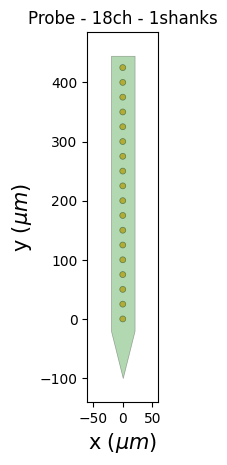

In [5]:
import json
from probeinterface import Probe
from probeinterface.plotting import plot_probe

probe_cars = dir_path / "probe.json"
with open(probe_cars, 'r') as f:
    probe_cars_dict = json.load(f)
positions = list(zip(probe_cars_dict['x'], probe_cars_dict['y']))
device_ids = list(range(traces_list.shape[1]))
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5})
probe.set_device_channel_indices(device_ids)
print(probe)
probe.create_auto_shape()
plot_probe(probe)

In [6]:
recording = recording.set_probe(probe)
# recording_cmr = recording
# recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
# print(recording_f)
# recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
# print(recording_cmr)

# # this computes and saves the recording after applying the preprocessing chain
# recording_preprocessed = recording_cmr.save(format="binary", folder=f"preprocessed_default_{example_name}_{condition}", overwrite=True)
# print(recording_preprocessed)

In [7]:
print("available sorters", ss.available_sorters())
# mountainsort4/5 はwindows非対応．
print("Installed sorters", ss.installed_sorters())

available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'mountainsort4', 'mountainsort5', 'pykilosort', 'rtsort', 'simple', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['kilosort4', 'simple', 'spykingcircus2', 'tridesclous2']


In [8]:
import psutil
import shutil
import os
import time
from pathlib import Path
from spikeinterface.sorters import run_sorter

def find_and_kill_locker(file_path):
    """
    指定されたファイルをロックしているプロセスを特定し、強制終了する関数。
    psutilライブラリを使用します。
    """
    target_path = Path(file_path).resolve()
    print(f"Searching for process locking: {target_path}")

    # すべての実行中プロセスを反復処理
    for proc in psutil.process_iter(['pid', 'name', 'open_files']):
        try:
            # プロセスが開いているファイルを確認
            if proc.info['open_files']:
                for item in proc.info['open_files']:
                    if Path(item.path).resolve() == target_path:
                        print(f"Found locking process: PID={proc.pid}, Name={proc.name}")
                        # 強制終了
                        proc.kill()
                        print(f"Process PID={proc.pid} has been terminated.")
                        return True
        except (psutil.NoSuchProcess, psutil.AccessDenied, FileNotFoundError):
            continue
    print("No process found locking the file.")
    return False

def save_with_cleanup(recording, folder, overwrite, n_jobs, total_memory):
    """
    ファイルロックエラー発生時に、ロックしているプロセスを終了させてから
    `recording.save()`を再試行するラッパー関数。
    """
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # save()を実行
            return recording.save(folder=folder, overwrite=overwrite, n_jobs=n_jobs, total_memory=total_memory)
        except PermissionError as e:
            if attempt < max_retries - 1:
                print(f"PermissionError caught: {e}. Retrying after cleanup...")
                # ロックしているプロセスを特定して終了を試みる
                if find_and_kill_locker(folder):
                    # プロセス終了後、少し待機して再試行
                    time.sleep(1)
                    continue
                else:
                    # ロッカーが見つからない場合は、手動でディレクトリ削除を試みる
                    try:
                        shutil.rmtree(folder)
                        print("Directory manually removed. Retrying save.")
                        time.sleep(1)
                        continue
                    except PermissionError as manual_e:
                        print(f"Manual removal failed: {manual_e}. The problem persists.")
                        raise manual_e
            else:
                print("Max retries reached. Failing to save.")
                raise e

def run_sorter_with_cleanup(sorter_name, recording, folder, **kwargs):
    """
    SpikeInterfaceのsorterを実行し、PermissionErrorが発生した場合は自己修復を試みる。
    """
    output_folder = Path(folder) / f"{sorter_name}_output"
    max_retries = 3
    retries = 0

    while retries < max_retries:
        try:
            print(f"Attempting to run sorter: {sorter_name}")
            sorting = run_sorter(sorter_name=sorter_name, recording=recording, folder=folder,
                                 remove_existing_folder=True, **kwargs)
            return sorting
        except PermissionError as e:
            print(f"PermissionError caught: {e}")
            if "The process cannot access the file" in str(e):
                print("File is locked. Attempting to find and kill the locking process.")
                if find_and_kill_locker(output_folder):
                    print("Locker terminated. Retrying sorter execution.")
                    retries += 1
                    continue
                else:
                    print("Failed to identify and terminate a locking process. Attempting manual removal.")
                    try:
                        shutil.rmtree(output_folder)
                        print("Directory successfully removed. Retrying sorter execution.")
                        retries += 1
                        continue
                    except PermissionError:
                        print("Manual removal failed. The problem persists.")
                        break
            else:
                raise # Re-raise if it's not the specific file lock error.

    raise RuntimeError("Failed to run sorter after multiple retries due to persistent file lock issues.")

In [75]:
sorters = ["kilosort4", "spykingcircus2"]
sorting_list = []
analyzer_list = []
# preprocess and run sort and make analyzer
for sorter in sorters:
    print("="*5, sorter, "="*5)
    try:
        if sorter == "kilosort4":
            
            pp_rec = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            pp_rec = spre.common_reference(pp_rec, reference="global")
            pp_rec = spre.whiten(pp_rec, int_scale=200)
            pp_rec = spre.correct_motion(pp_rec, preset="kilosort_like")
            pp_rec = pp_rec.save(folder=f"preprocessed_data_for_{sorter}_{example_name}_{condition}",overwrite=True, n_jobs=8, total_memory="2G")
            # pp_rec = save_with_cleanup(pp_rec, folder=f"preprocessed_data_for_{sorter}_{example_name}_{condition}", overwrite=True, n_jobs=8, total_memory="2G")
            recording_preprocessed = pp_rec
        else:
            recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
            recording_cmr = spre.common_reference(recording_f, reference="global", operator="median")
            recording_preprocessed = recording_cmr.save(format="binary", folder=f"preprocessed_default_{example_name}_{condition}", overwrite=True)
        
        sorting = ss.run_sorter(sorter_name=sorter, folder=f"{sorter}_{example_name}_{condition}" , remove_existing_folder=True, recording=recording_preprocessed)
        # sorting = run_sorter_with_cleanup(sorter_name=sorter, folder=f"{sorter}_{example_name}_{condition}" , remove_existing_folder=True, recording=recording_preprocessed)
        print(sorting)
        sorting_list.append(sorting)

        analyzer = si.create_sorting_analyzer(sorting=sorting, recording=recording_preprocessed, format='binary_folder', folder=f'analyzer_{sorter}_{example_name}_{condition}', overwrite=True)
        print(analyzer)
        analyzer_list.append(analyzer)
    finally:
        if 'pp_rec' in locals():
            del pp_rec
        if 'recording_preprocessed' in locals():
            del recording_preprocessed

===== kilosort4 =====


noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\sortingcomponents\motion\motion_utils.py:82: UserWarning: You are trying to estimate motion with `non-rigid` on a probe that is too short!get_spatial_windows(): win_step_um=200.0/win_scale_um=400.0/win_margin_um=-200.0 are too large for the probe size (depth range=425.0). Switching to rigid motion.
  warnings.warn(
c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\core\base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")


write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=6,944,444 - chunk_memory=476.84 MiB - total_memory=1.86 GiB - chunk_duration=231.48s (3.86 minutes)


write_binary_recording (workers: 1 processes):   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 61.68it/s]


KiloSortSortingExtractor: 9 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")
c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\core\base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")


SortingAnalyzer: 18 channels - 9 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions
===== spykingcircus2 =====
write_binary_recording 
engine=process - n_jobs=4 - samples_per_chunk=30,000 - chunk_memory=1.03 MiB - total_memory=4.12 MiB - chunk_duration=1.00s


write_binary_recording (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\core\sortinganalyzer.py:487: UserWarning: The Recording is not serializable! The recording link will be lost for future load
  warnings.warn("The Recording is not serializable! The recording link will be lost for future load")


NumpyFolder (NumpyFolderSorting): 48 units - 1 segments - 30.0kHz


estimate_sparsity (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

create_sorting_analyzer: recording does not have scaling to uV, forcing return_in_uV=False
SortingAnalyzer: 18 channels - 48 units - 1 segments - binary_folder - sparse - has recording
Loaded 0 extensions


c:\Users\tanaka-users\tlab\tlab_yasui\2025\spikeinterface\.venv\Lib\site-packages\spikeinterface\core\basesorting.py:380: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


In [76]:
extensions_to_compute = [
    "random_spikes",
    "waveforms",
    "noise_levels",
    "templates",
    "spike_amplitudes",
    "unit_locations",
    "spike_locations",
    "correlograms",
    "template_similarity"
]

extension_params = {
    "unit_locations": {"method": "center_of_mass"},
    "spike_locations": {"ms_before": 0.1},
    "correlograms": {"bin_ms": 0.1},
    "template_similarity": {"method": "cosine_similarity"}
}
for analyzer_index, analyzer in enumerate(analyzer_list):
    print("="*5, sorters[analyzer_index], "="*5)
    analyzer.compute(extensions_to_compute, extension_params=extension_params)
    del analyzer


===== kilosort4 =====


compute_waveforms (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

===== spykingcircus2 =====


compute_waveforms (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 4 processes):   0%|          | 0/10 [00:00<?, ?it/s]

===== kilosort4 =====
===== spykingcircus2 =====


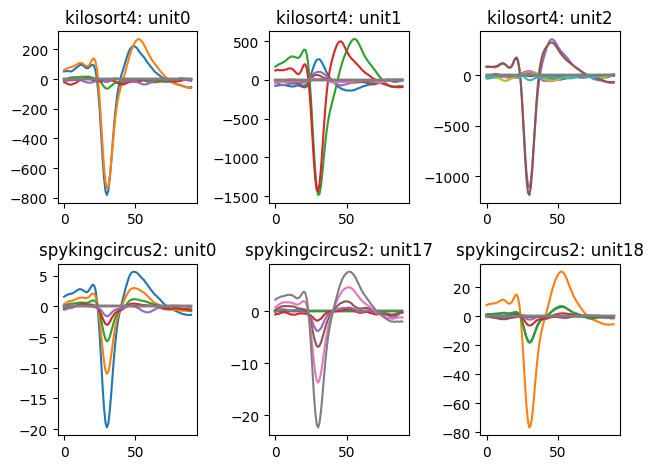

In [77]:
n = len(analyzer_list)
n_unit = 3
fig, ax = plt.subplots(n,n_unit)
for analyzer_index, analyzer in enumerate(analyzer_list):
    print("="*5, sorters[analyzer_index], "="*5)
    for unit_index, unit_id in enumerate(analyzer.unit_ids[:n_unit]):
        template = analyzer.get_extension("templates").get_data(operator="average")[unit_index]
        ax[analyzer_index,unit_index].plot(template)
        ax[analyzer_index,unit_index].set_title(f"{sorters[analyzer_index]}: unit{unit_id}")
fig.tight_layout()

In [78]:
comp_gt_list = []
for sorting_index, sorting in enumerate(sorting_list):
    print("="*5, sorters[sorting_index], "="*5)
    comp_gt = sc.compare_sorter_to_ground_truth(
        gt_sorting=gt_sorting, 
        tested_sorting=sorting, 
        agreement_method="count",
        )
    comp_gt_list.append(comp_gt)
    print(comp_gt)
# comp_pair = sc.compare_two_sorters(sorting1=sorting_KS4, sorting2=sorting_SC2)
# comp_multi = sc.compare_multiple_sorters(
#     sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2], name_list=["tdc", "sc2", "ks2"]
# )

===== kilosort4 =====
===== spykingcircus2 =====


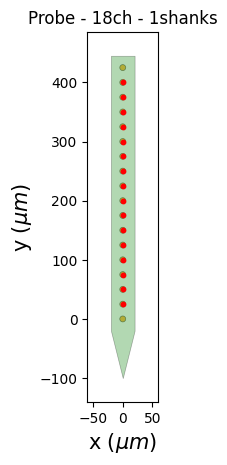

In [91]:
gt_unit_positions = np.load(dir_path / "cell_positions.npy")
plot_probe(probe)
plt.scatter(gt_unit_positions[:,0], gt_unit_positions[:,1], c="red", s=10)

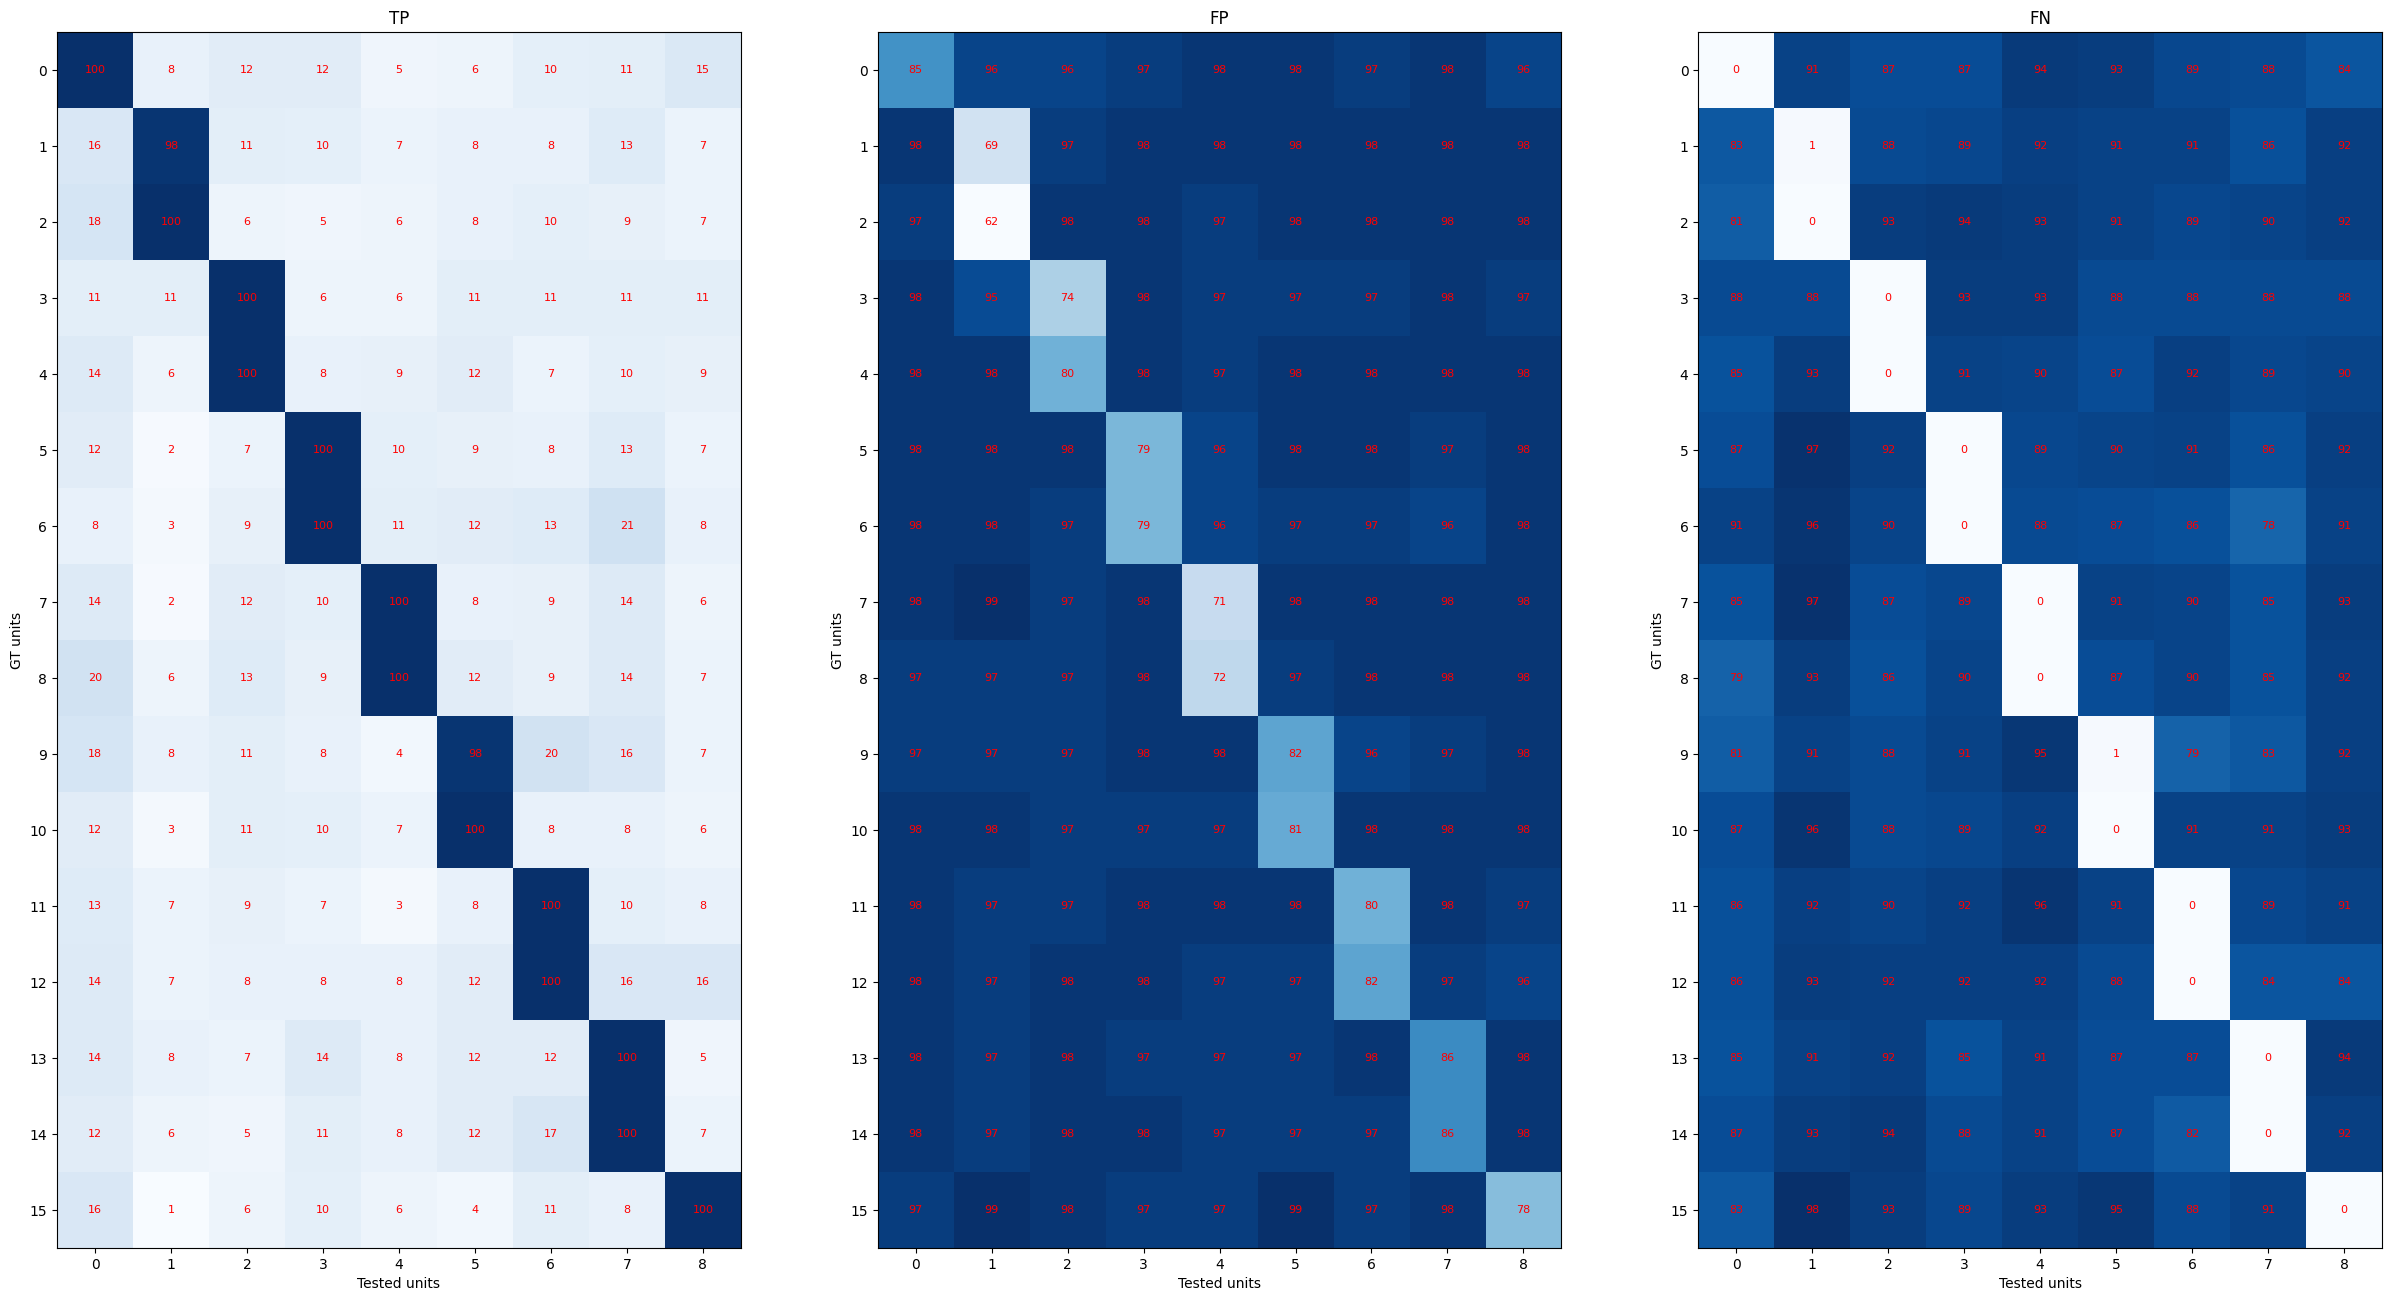

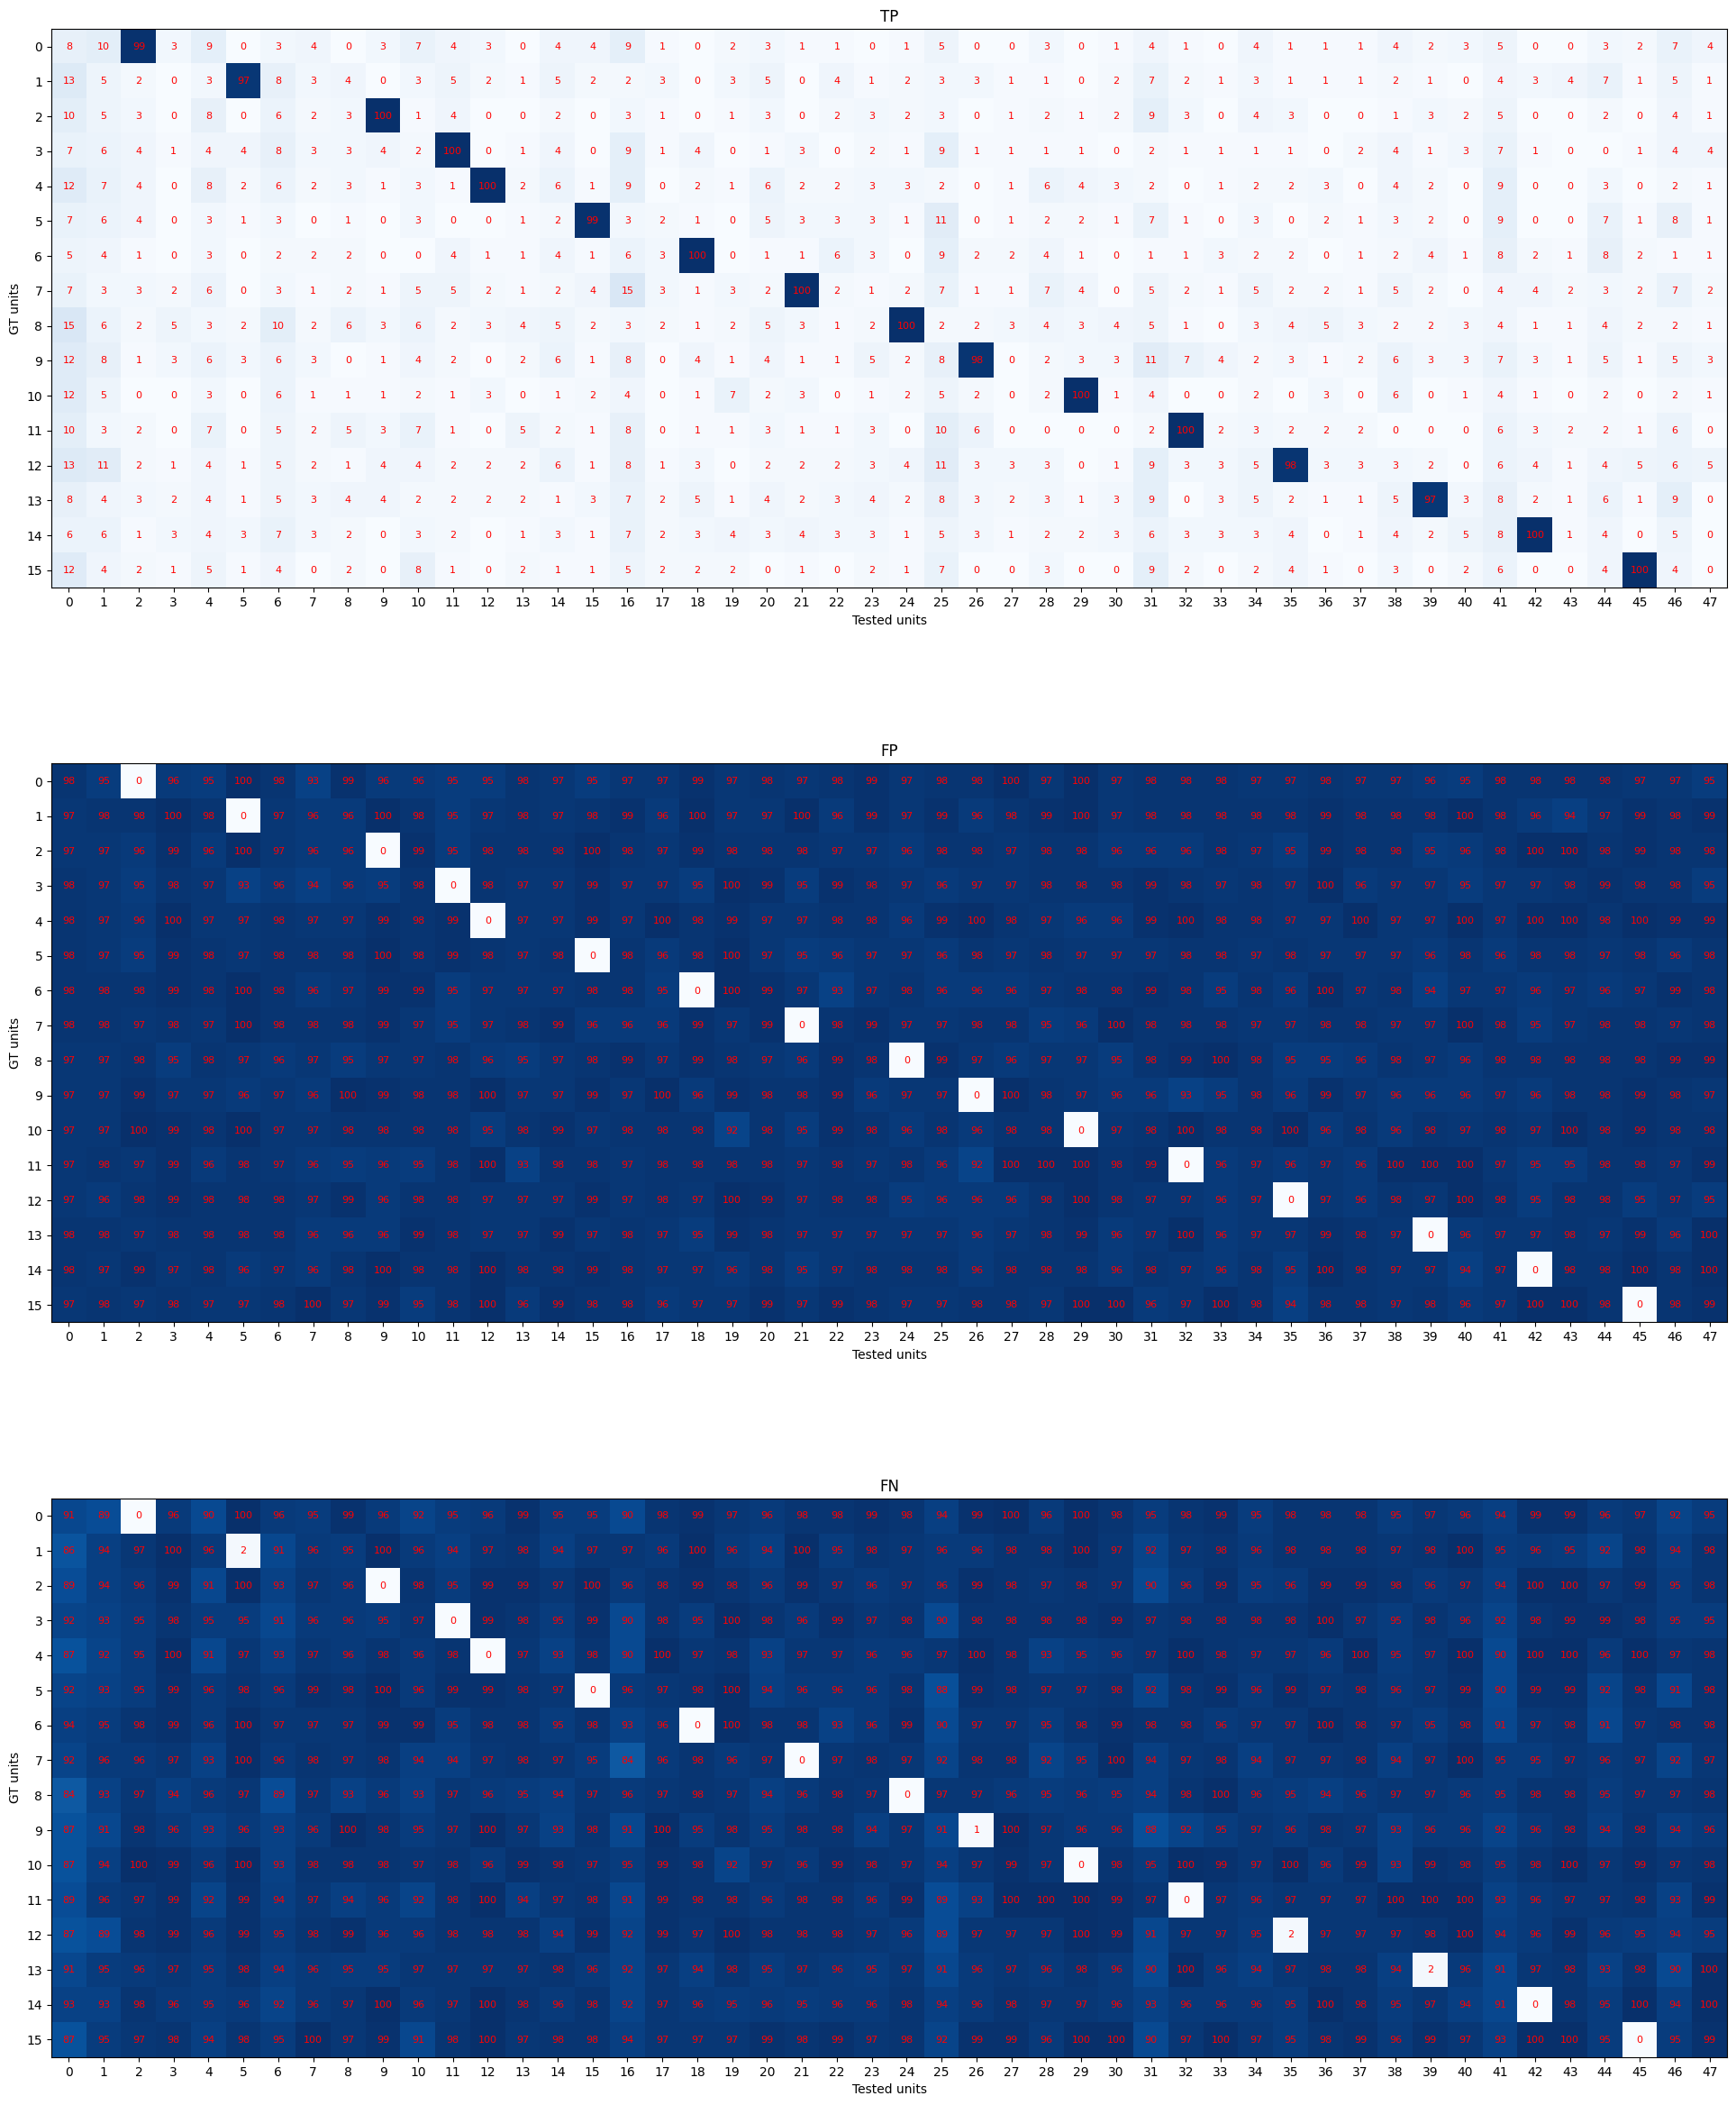

In [79]:
import numpy as np
from typing import List

def compare_spike_times(gt_sorting, tested_sorting, delta_time_ms: float, fs: float, mode: str = "rate") -> np.ndarray:
    """
    Compares two lists of spike times and builds a simple agreement matrix.
    This function allows for one-to-many matching.

    Args:
        gt_sorting: The Ground Truth sorting object.
        tested_sorting: The tested sorting object.
        delta_time_ms (float): The time tolerance for matching, in milliseconds.
        fs (float): The sampling frequency in Hz.
        mode (str): The mode to calculate matrix. "rate" or "count".
    Returns:
        np.ndarray: An agreement matrix where rows correspond to GT units and columns correspond to tested units. The values are the number of matching spikes.
    """
    # Convert delta_time from ms to frames
    delta_time_frames = delta_time_ms * fs / 1000

    gt_unit_ids = gt_sorting.get_unit_ids()
    gt_spike_times = {unit_id: gt_sorting.get_unit_spike_train(unit_id) for unit_id in gt_unit_ids}
    tested_unit_ids = tested_sorting.get_unit_ids()
    tested_spike_times = {unit_id: tested_sorting.get_unit_spike_train(unit_id) for unit_id in tested_unit_ids}
    n_gt = len(gt_unit_ids)
    n_tested = len(tested_unit_ids)
    TP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FP_matrix = np.zeros((n_gt, n_tested), dtype=int)
    FN_matrix = np.zeros((n_gt, n_tested), dtype=int)

    # Correct iteration: Iterate through the individual spike time arrays
    for i, gt_id in enumerate(gt_unit_ids):
        gt_unit_spikes = gt_spike_times[gt_id]
        if gt_unit_spikes.size == 0:
            continue
        
        for j, tested_id in enumerate(tested_unit_ids):
            tested_unit_spikes = tested_spike_times[tested_id]
            if tested_unit_spikes.size == 0:
                continue

            matches = 0
            
            # The original code had a bug here.
            # It was iterating over a list of arrays, not a single array.
            
            # Correct logic: for each tested spike, find a match in the GT unit's array
            for gt_spike_time in gt_unit_spikes:
                # np.searchsorted must be used on a single, 1D array
                idx = np.searchsorted(tested_unit_spikes, gt_spike_time)
                
                found_match = False
                if idx < len(tested_unit_spikes) and np.abs(tested_unit_spikes[idx] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                elif idx > 0 and np.abs(tested_unit_spikes[idx-1] - gt_spike_time) <= delta_time_frames:
                    found_match = True
                
                if found_match:
                    matches += 1
                    
            TP_matrix[i, j] = matches if mode == "count" else matches / len(gt_unit_spikes) * 100
            FP_matrix[i, j] = len(tested_unit_spikes) - matches if mode == "count" else ((len(tested_unit_spikes) - matches) / len(tested_unit_spikes) * 100)
            FN_matrix[i, j] = len(gt_unit_spikes) - matches if mode == "count" else ((len(gt_unit_spikes) - matches) / len(gt_unit_spikes) * 100)
            
    return TP_matrix, FP_matrix, FN_matrix

def plot_matrix(matrix, title, gt_unit_num, tested_unit_num, ax):
    im = ax.imshow(matrix, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Tested units")
    ax.set_ylabel("GT units")
    ax.set_xticks(range(tested_unit_num))
    ax.set_yticks(range(gt_unit_num))
    
    # 各セルに値を書き込む
    for i in range(gt_unit_num):
        for j in range(tested_unit_num):
            text = ax.text(j, i, f'{matrix[i, j]}',
                         ha="center", va="center", color="red", fontsize=8)

    # Example usage
# You need to specify a sampling frequency (fs) and a jitter threshold (delta_time_ms)
sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds

# Calculate the agreement matrix
for i, sorting in enumerate(sorting_list):
    TP_matrix, FP_matrix, FN_matrix = compare_spike_times(
        gt_sorting=gt_sorting,
        tested_sorting=sorting,
        delta_time_ms=time_threshold_ms,
        fs=sampling_frequency,
        mode="rate"
    )

    if len(gt_sorting.get_unit_ids()) > len(sorting_list[i].get_unit_ids()):
        fig, ax = plt.subplots(1, 3, figsize=(30,24))
    else:
        fig, ax = plt.subplots(3, 1, figsize=(24,30))
    plot_matrix(TP_matrix, "TP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[0])
    plot_matrix(FP_matrix, "FP", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[1])
    plot_matrix(FN_matrix, "FN", len(gt_sorting.get_unit_ids()), len(sorting_list[i].get_unit_ids()), ax[2])
    # fig.tight_layout()

===== kilosort4 ===== 
 single: [], 
 multi: [0, 1, 2, 3, 4, 5, 6, 7, 8]
===== spykingcircus2 ===== 
 single: [18, 19, 21, 23, 25, 27, 28, 29, 31, 33, 34, 35, 37, 38, 40, 42, 43, 45, 46, 48, 49, 50, 51, 53, 55, 58, 59, 61, 63], 
 multi: [0, 17, 20, 22, 24, 26, 30, 32, 36, 39, 41, 44, 47, 52, 54, 56, 57, 60, 62]


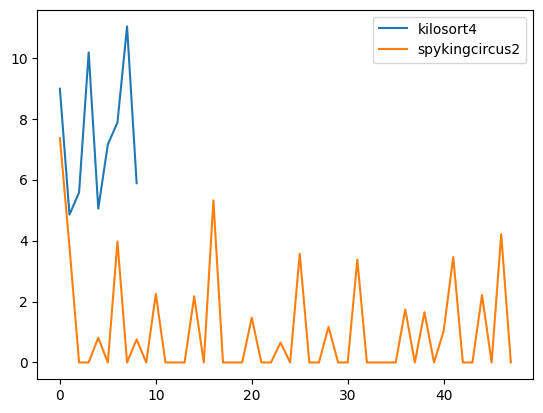

In [86]:
def get_isi(spike_times):
    isi = np.diff(spike_times)
    return isi

def get_isi_violation_rate(spike_times, threshold_ms=2.0, sampling_frequency=30000.0):
    isi = get_isi(spike_times)
    isi_violation = np.sum(isi < threshold_ms * sampling_frequency / 1000) / len(isi) * 100
    return isi_violation

def get_isi_violation_rate_by_unit(sorting, threshold_ms=2.0, sampling_frequency=30000.0, dtype="dict"):
    isi_violation = {}
    for unit_id in sorting.get_unit_ids():
        isi_violation[unit_id] = get_isi_violation_rate(sorting.get_unit_spike_train(unit_id), threshold_ms, sampling_frequency)
    if dtype == "dict":
        return isi_violation
    elif dtype == "list":
        return list(isi_violation.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

def get_single_multi_unit(sorting, threshold_rate=50, threshold_ms=2.0, sampling_frequency=30000.0, unit_type="both"):
    single_unit = []
    multi_unit = []
    isi_violation = get_isi_violation_rate_by_unit(sorting, threshold_ms, sampling_frequency)
    unit_ids = sorting.get_unit_ids()
    for i, unit_id in enumerate(unit_ids):
        if isi_violation[unit_id] > threshold_rate:
            multi_unit.append(int(unit_id))
        else:
            single_unit.append(int(unit_id))

    try:    
        if unit_type == "single":
            return single_unit
        elif unit_type == "multi":
            return multi_unit
        elif unit_type == "both":
            return single_unit, multi_unit
    except:
        ValueError("unit_type must be 'single', 'multi', or 'both'")
    
        

sampling_frequency = 30000.0  # Hz
time_threshold_ms = 1.0      # milliseconds
mua_threshold_rate = 0.2
for i, sorting in enumerate(sorting_list):
    isi_violation_dict = get_isi_violation_rate_by_unit(sorting)
    isi_violation_values = list(isi_violation_dict.values())
    plt.plot(isi_violation_values, label=sorters[i])
    print("="*5, f"{sorters[i]}", "="*5, f"\n single: {get_single_multi_unit(sorting, threshold_rate=mua_threshold_rate, unit_type="single")}, \n multi: {get_single_multi_unit(sorting, threshold_rate=mua_threshold_rate, unit_type="multi")}")
plt.legend()


ISI Violation Rate Scatter Matrix:


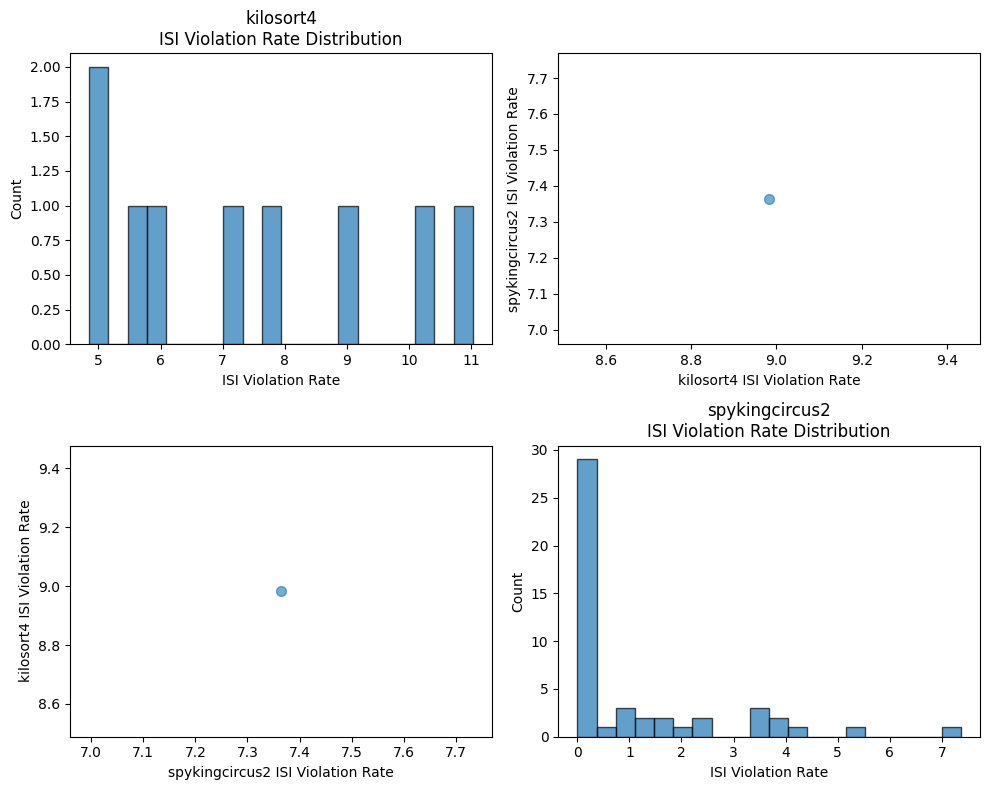

In [93]:
# 散布図行列を作成する関数
def create_scatter_matrix(sorting_list, sorters, metrics_func, metric_name, figsize=(12, 8)):
    """
    複数のソーターの結果を比較する散布図行列を作成
    
    Args:
        sorting_list: ソーターの結果のリスト
        sorters: ソーター名のリスト
        metrics_func: メトリクスを計算する関数
        metric_name: メトリクスの名前
        figsize: 図のサイズ
    """
    n_sorters = len(sorting_list)
    
    # 各ソーターのメトリクスを計算
    metrics_data = {}
    for i, sorting in enumerate(sorting_list):
        metrics_data[sorters[i]] = metrics_func(sorting)
    
    # 散布図行列を作成
    fig, axes = plt.subplots(n_sorters, n_sorters, figsize=figsize)
    
    # axesの配列構造を統一
    if n_sorters == 1:
        axes = np.array([[axes]])
    elif n_sorters == 2:
        axes = axes.reshape(2, 2)
    
    for i in range(n_sorters):
        for j in range(n_sorters):
            ax = axes[i, j]
            
            if i == j:
                # 対角線：ヒストグラム
                values = list(metrics_data[sorters[i]].values())
                ax.hist(values, bins=20, alpha=0.7, edgecolor='black')
                ax.set_title(f'{sorters[i]}\n{metric_name} Distribution')
                ax.set_xlabel(metric_name)
                ax.set_ylabel('Count')
            else:
                # 非対角線：散布図
                sorter1 = sorters[i]
                sorter2 = sorters[j]
                
                # 共通のユニットIDを取得
                common_units = set(metrics_data[sorter1].keys()) & set(metrics_data[sorter2].keys())
                
                if common_units:
                    x_values = [metrics_data[sorter1][unit_id] for unit_id in common_units]
                    y_values = [metrics_data[sorter2][unit_id] for unit_id in common_units]
                    
                    ax.scatter(x_values, y_values, alpha=0.6, s=50)
                    
                    # 相関係数を計算
                    if len(x_values) > 1:
                        correlation = np.corrcoef(x_values, y_values)[0, 1]
                        ax.text(0.05, 0.95, f'r = {correlation:.3f}', 
                               transform=ax.transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    ax.set_xlabel(f'{sorter1} {metric_name}')
                    ax.set_ylabel(f'{sorter2} {metric_name}')
                else:
                    ax.text(0.5, 0.5, 'No common units', 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_xlabel(f'{sorter1} {metric_name}')
                    ax.set_ylabel(f'{sorter2} {metric_name}')
    
    plt.tight_layout()
    return fig

# ISI違反率の散布図行列を作成
print("ISI Violation Rate Scatter Matrix:")
fig1 = create_scatter_matrix(
    sorting_list, 
    sorters, 
    get_isi_violation_by_unit, 
    "ISI Violation Rate",
    figsize=(10, 8)
)
plt.show()


Spike Count Scatter Matrix:


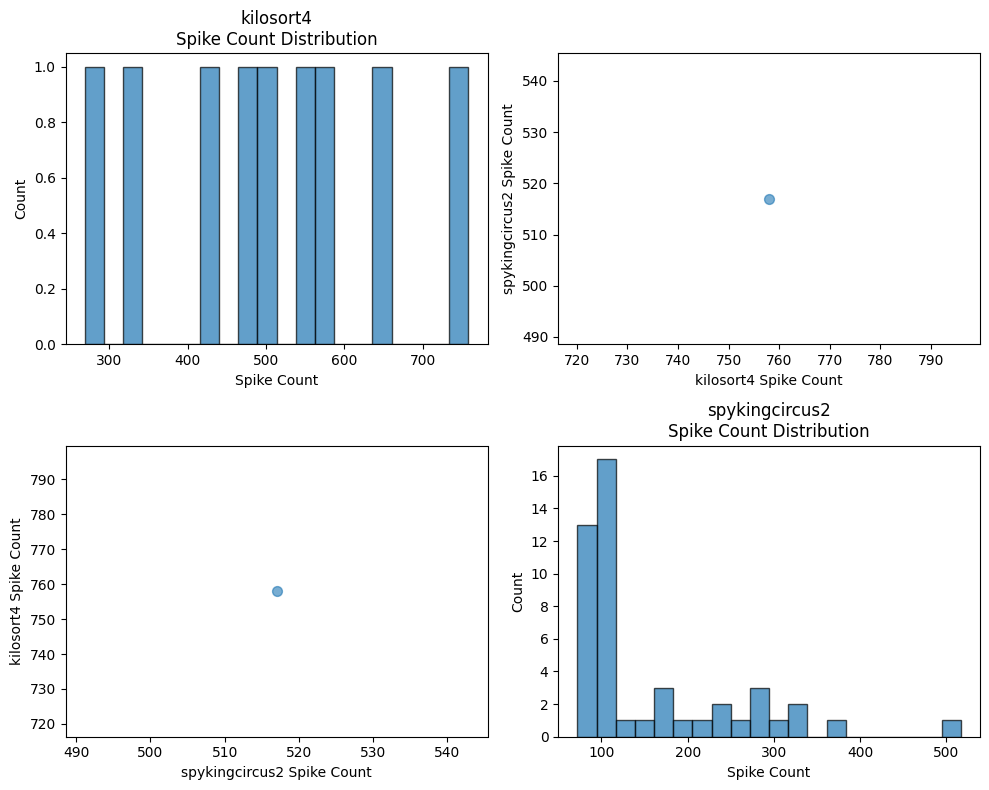

Firing Rate Scatter Matrix:


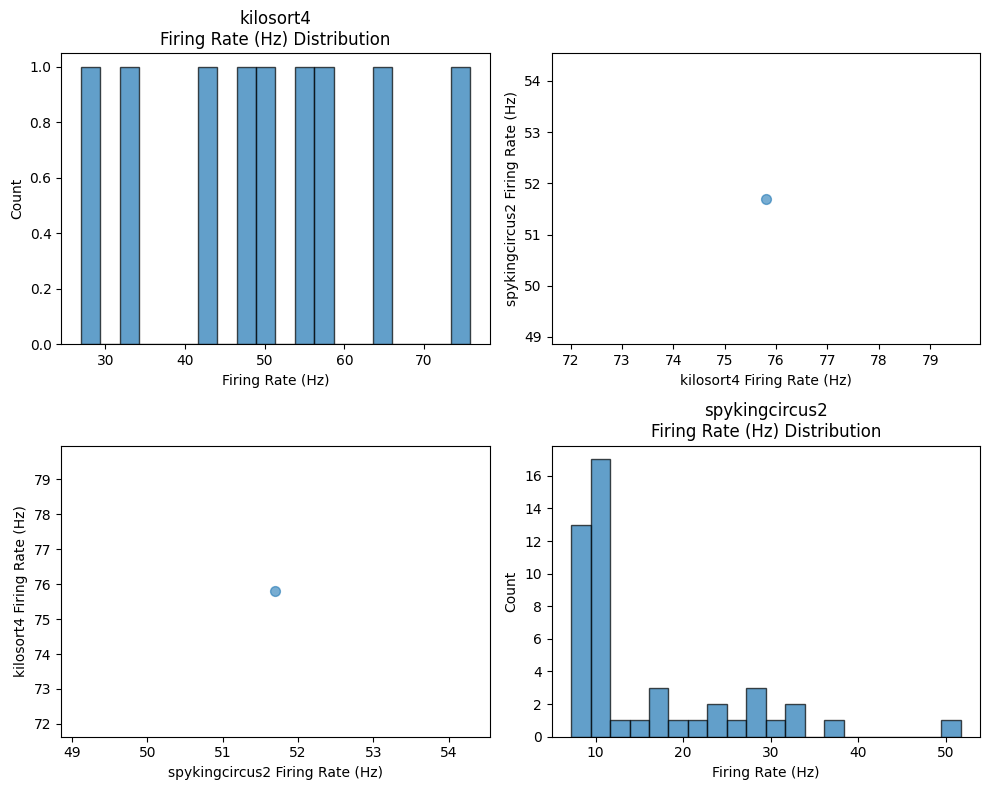

In [94]:
# ユニット数とスパイク数の散布図行列を作成
def get_unit_spike_counts(sorting):
    """各ユニットのスパイク数を取得"""
    spike_counts = {}
    for unit_id in sorting.get_unit_ids():
        spike_train = sorting.get_unit_spike_train(unit_id)
        spike_counts[unit_id] = len(spike_train)
    return spike_counts

def get_unit_firing_rates(sorting, sampling_frequency=30000.0):
    """各ユニットの発火率を取得（Hz）"""
    firing_rates = {}
    for unit_id in sorting.get_unit_ids():
        spike_train = sorting.get_unit_spike_train(unit_id)
        if len(spike_train) > 0:
            # レコーディングの長さを取得（サンプル数）
            recording_duration_samples = sorting.get_total_samples()
            recording_duration_seconds = recording_duration_samples / sampling_frequency
            firing_rates[unit_id] = len(spike_train) / recording_duration_seconds
        else:
            firing_rates[unit_id] = 0.0
    return firing_rates

# スパイク数の散布図行列
print("Spike Count Scatter Matrix:")
fig2 = create_scatter_matrix(
    sorting_list, 
    sorters, 
    get_unit_spike_counts, 
    "Spike Count",
    figsize=(10, 8)
)
plt.show()

# 発火率の散布図行列
print("Firing Rate Scatter Matrix:")
fig3 = create_scatter_matrix(
    sorting_list, 
    sorters, 
    get_unit_firing_rates, 
    "Firing Rate (Hz)",
    figsize=(10, 8)
)
plt.show()


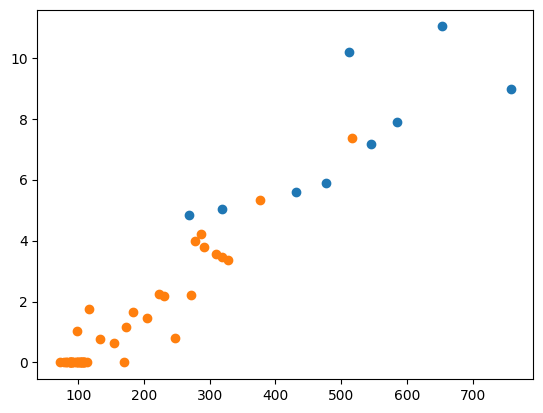

In [87]:
def get_spike_num_by_unit(sorting, dtype="dict"):
    spike_num = {}
    for unit_id in sorting.get_unit_ids():
        spike_num[unit_id] = len(sorting.get_unit_spike_train(unit_id))
    if dtype == "dict":
        return spike_num
    elif dtype == "list":
        return list(spike_num.values())
    else:
        ValueError("dtype must be 'dict' or 'list'")

for i, sorting in enumerate(sorting_list):
    isi_violation_list = get_isi_violation_rate_by_unit(sorting, dtype="list")
    spike_num_list = get_spike_num_by_unit(sorting, dtype="list")
    plt.scatter(spike_num_list, isi_violation_list, label=sorters[i])

In [81]:
# for i, comp_gt in enumerate(comp_gt_list):
#     print("="*5, sorters[i], "="*5)
#     print(comp_gt.get_performance(method="by_unit"))
#     if len(gt_sorting.get_unit_ids()) > len(sorting_list[i].get_unit_ids()):
#         fig, ax = plt.subplots(1, 2, figsize=(10,8))
#     else:
#         fig, ax = plt.subplots(2, 1, figsize=(10,8))
        
#     # 混同行列
#     sw.plot_confusion_matrix(
#         comp_gt,
#         unit_ticks=True,
#         count_text=True,
#         ax=ax[0], 
#     )

#     # 合意行列
#     w_agr = sw.plot_agreement_matrix(
#         comp_gt, 
#         ordered=False, 
#         count_text=True, 
#         unit_ticks=False, 
#         ax=ax[1],
#     )
#     ax[0].set_title(f"{sorters[i]} confusion")
#     ax[1].set_title(f"{sorters[i]} agreement")
#     fig.tight_layout()

In [82]:
# sw.plot_all_amplitudes_distributions(analyzer_list[0])
# sw.plot_amplitudes(analyzer_list[0])
# sw.plot_autocorrelograms(analyzer_list[0])
# # sw.plot_comparison_collision_by_similarity(
# #     comp_gt_list[0], 
# #     templates_array=np.load(dir_path / "spike_templates.npy", allow_pickle=True).T,
# #     )
# sw.plot_crosscorrelograms(analyzer_list[0])
# sw.plot_isi_distribution(analyzer_list[0])


In [83]:
# sw.plot_multicomparison_agreement(comp_gt_list[0])
# sw.plot_multicomparison_agreement_by_sorter(comp_gt_list[0])
# sw.plot_multicomparison_graph(comp_gt_list[0])
# sw.plot_peak_activity(recording, analyzer_list[0].get_detect_peaks())
# sw.plot_probe_map(recording)
# # sw.plot_quality_metrics(analyzer_list[0])
# sw.plot_rasters(analyzer_list[0])

# sw.plot_sorting_summary(analyzer_list[0], backend="spikeinterface_gui")